In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
plt.style.use('ggplot')

## Load dataset and pickles

In [2]:
with open('data/nyc_network_graph.pkl', 'r') as f:
    G = pickle.load(f)

In [3]:
data_path = '../analytics/data/taxi_trips/mmdata_2016-05.csv'
dataset = pd.read_csv(data_path, nrows=500000)
dataset = dataset[['trip_time', 'phash', 'plat', 'plon', 'dhash', 'dlat', 'dlon', 'second']]
dayofweek0 = 6
dataset.head()

,trip_time,phash,plat,plon,dhash,dlat,dlon,second
0,17.516667,dr5rumt,40.768249,-73.985475,dr5rsqw,40.729667,-73.983788,0
1,7.016667,dr5ru0z,40.742039,-73.993433,dr5ru92,40.744732,-73.980941,0
2,19.783333,dr5rkq2,40.684367,-73.992064,dr5rsp1,40.732507,-74.001829,0
3,7.516667,dr5ru32,40.745078,-73.992071,dr5ruth,40.765470,-73.975744,0
4,6.650000,dr5rgbx,40.740652,-74.004656,dr5ru0h,40.737793,-73.997871,0


In [4]:
with open('model/pickle/demand_predictor.pkl', 'r') as f:
    demand_model = pickle.load(f)

In [5]:
from model.eta import ETA
with open('model/pickle/triptime_predictor.pkl', 'r') as f:
    eta_model = ETA(pickle.load(f))

od_distance = pd.read_csv('data/OD_distance.csv', index_col='taxi_zone')
eta_model.set_dataframe(od_distance)

In [6]:
from keras.models import model_from_json
from model.pdest import Pdest

with open('model/dest_model/model.json', 'r') as f:
    pdest_model = model_from_json(f.read())
pdest_model.load_weights('model/dest_model/model.h5')

zone_df = od_distance[['lat', 'lon']]
pdest_model = Pdest(pdest_model, zone_df)

Using TensorFlow backend.


In [7]:
from simulator import FleetSimulator
from agent import Agent

In [8]:
import time

def run(simulator, agent, T, reposition_cycle=15, taxi_zone=78, verbose=True):
    vehicles, requests, reward = simulator.forward()    
    result = np.zeros((T, 12))
    Wp = 0
    wp_z = 0
    U = 0
    u_z = 0
    hash_in_zone = agent.state[agent.state.taxi_zone==taxi_zone].index
    start = time.time()

    for t in range(T):
        if t % 60 == 0 and verbose:
            elapsed_time = time.time() - start
            print "hour %d: elapsed %d" % (t/60.0, elapsed_time)
            start = time.time()

        assignments = agent.match(vehicles, requests)
        vehicles, wait, reject = simulator.assign(assignments)
        X = sum(vehicles.available)
        W = len(requests)
        x_z = sum([1 for g in vehicles[vehicles.available==1]['geohash'].values if g in hash_in_zone])  
        w_z = sum([1 for g in requests['phash'].values if g in hash_in_zone])
        reject_z = w_z - sum([1 for g in requests.loc[[i for i, _ in assignments], 'phash'] if g in hash_in_zone])
        
        if t > 0 and t % reposition_cycle == 0:
            actions, state, objective = agent.reposition(vehicles)
            Wp = state.W.sum()
            wp_z = state.loc[taxi_zone, 'W']
            U = len(actions)
            u_z = state.loc[taxi_zone, 'flow']
            simulator.reposition(actions)
            
            if verbose:
                print "t: %d\t total_flow: %d\t objective: %d" % (t, U, objective)

        vehicles, requests, cost = simulator.forward()
        result[int(t), :] = (X, W, wait, reject, cost, Wp, U, x_z, w_z, reject_z, wp_z, u_z)

    result = pd.DataFrame(result, columns=[
        'X', 'W', 'wait', 'reject', 'cost', 'Wp', 'U',
        'x_z', 'w_z', 'reject_z', 'wp_z', 'u_z'
    ])    
    print "Total requests: %d" % result.W.sum()
    print "Total rejects: %d" % result.reject.sum()
    print "Total cost: %d" % result.cost.sum()
    print "Mean wait time: %.2f" % (result.wait.sum()/(result.W.sum()-result.reject.sum()))

    return result

In [9]:
def summary(result):
    print result.W.sum()
    print result.reject.sum()
    print result.cost.sum()
    print (result.wait.sum()/(result.W.sum()-result.reject.sum()))

In [10]:
def plot_result(result, reposition_cycle=15):
    plt.figure(figsize=(10, 10))
    plt.subplot(311)
    plt.ylabel('count')
    plt.ylim([0, 100])
    plt.plot(result.index, result.w_z, label='demand')
    plt.plot(result.index, result.reject_z, label='reject')
    plt.plot(result.index, result.u_z, label='reposition')
    plt.plot(result.index, result.wp_z/reposition_cycle, label='prediction')
    plt.plot(result.index, result.x_z, label='vehicle')
    plt.legend()
    plt.subplot(312)
    plt.ylabel('total_count')
    plt.plot(result.index, result.W, label='demand')
    plt.plot(result.index, result.reject, label='reject')
    plt.plot(result.index, result.U, label='reposition')
    plt.plot(result.index, result.Wp/reposition_cycle, label='prediction')
    plt.plot(result.index, result.X/10, label='vehicle/10')
    plt.legend()
    plt.subplot(313)
    plt.ylabel('wait time')
    plt.plot(result.index, result.wait/(result.W-result.reject))
    return plt

## Setup simulator and agent

In [14]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)

geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, dayofweek=dayofweek0)

In [15]:
%%time
result = run(simulator, agent, T=60*24, reposition_cycle=1e10)

hour 0
hour 1
hour 2
hour 3
hour 4
hour 5
hour 6
hour 7
hour 8
hour 9
hour 10
hour 11
hour 12
hour 13
hour 14
hour 15
hour 16
hour 17
hour 18
hour 19
hour 20
hour 21
hour 22
hour 23
Total requests: 415868
Total rejects: 83180
Total cost: 0
Mean wait time: 4.21
CPU times: user 4min 55s, sys: 45.3 s, total: 5min 41s
Wall time: 5min 45s


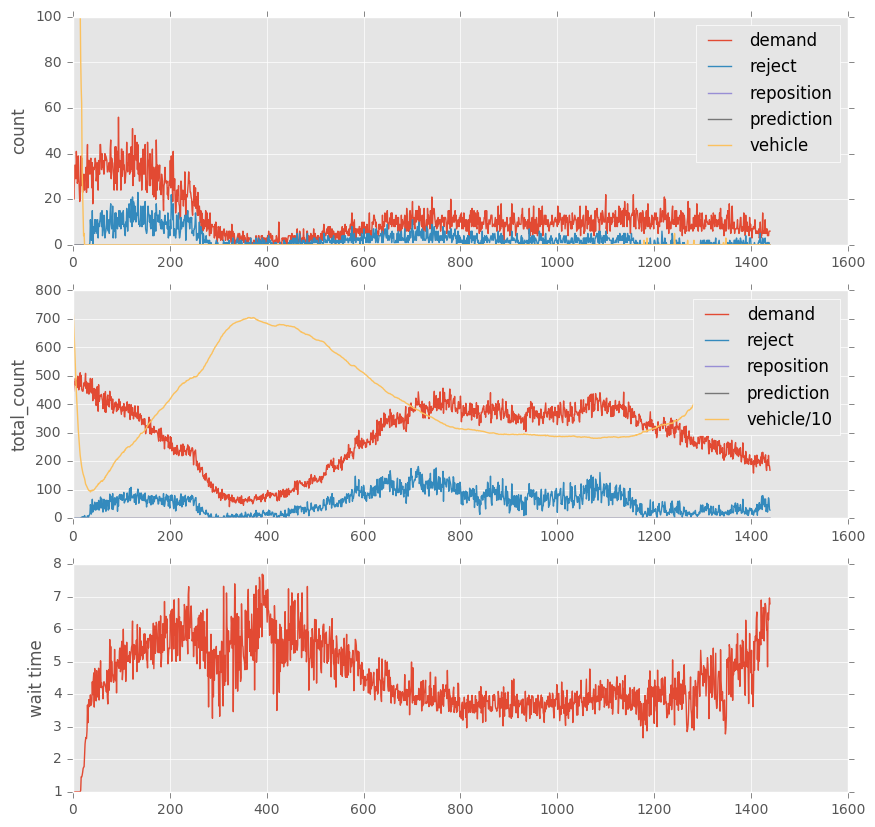

In [16]:
plot_result(result);

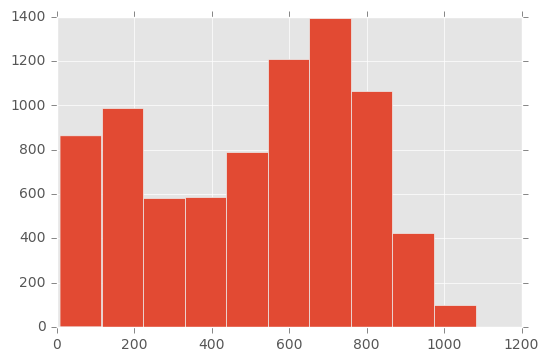

In [20]:
vrecords = simulator.get_vehicles_record()
vrecords.total_service_time.hist();

In [23]:
# from mapper.geohelper import plot_overmap

# shape_file_path = "../analytics/data/taxi_zones/taxi_zones.shp"
# vehicles, requests, reward = simulator.forward()    
# point_y = vehicles[vehicles.available==1].lat.values
# point_x = vehicles[vehicles.available==1].lon.values
# radius=0.001
# plot_overmap(point_x, point_y, radius, shape_file_path)

## Linear Programming Policy

In [16]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)

rcycle = 15
tmax = 25
rcost = 1.0
penalty = 30.0
svv_param = 0.7
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_param=svv_param)

In [17]:
%%time
result = run(simulator, agent, T=60*24, reposition_cycle=rcycle)

hour 0: elapsed 0
t: 15	 total_flow: 17	 objective: 181960
t: 30	 total_flow: 244	 objective: 221903
t: 45	 total_flow: 345	 objective: 247150
hour 1: elapsed 144
t: 60	 total_flow: 525	 objective: 253840
t: 75	 total_flow: 557	 objective: 248538
t: 90	 total_flow: 732	 objective: 221729
t: 105	 total_flow: 703	 objective: 218409
hour 2: elapsed 254
t: 120	 total_flow: 737	 objective: 213695
t: 135	 total_flow: 825	 objective: 210314
t: 150	 total_flow: 949	 objective: 175590
t: 165	 total_flow: 1150	 objective: 159172
hour 3: elapsed 315
t: 180	 total_flow: 1085	 objective: 140747
t: 195	 total_flow: 1307	 objective: 121257
t: 210	 total_flow: 1044	 objective: 65552
t: 225	 total_flow: 1135	 objective: 55875
hour 4: elapsed 307
t: 240	 total_flow: 1243	 objective: 57784
t: 255	 total_flow: 1120	 objective: 53350
t: 270	 total_flow: 116	 objective: 17165
t: 285	 total_flow: 187	 objective: 11252
hour 5: elapsed 232
t: 300	 total_flow: 178	 objective: 10034
t: 315	 total_flow: 163	 obje

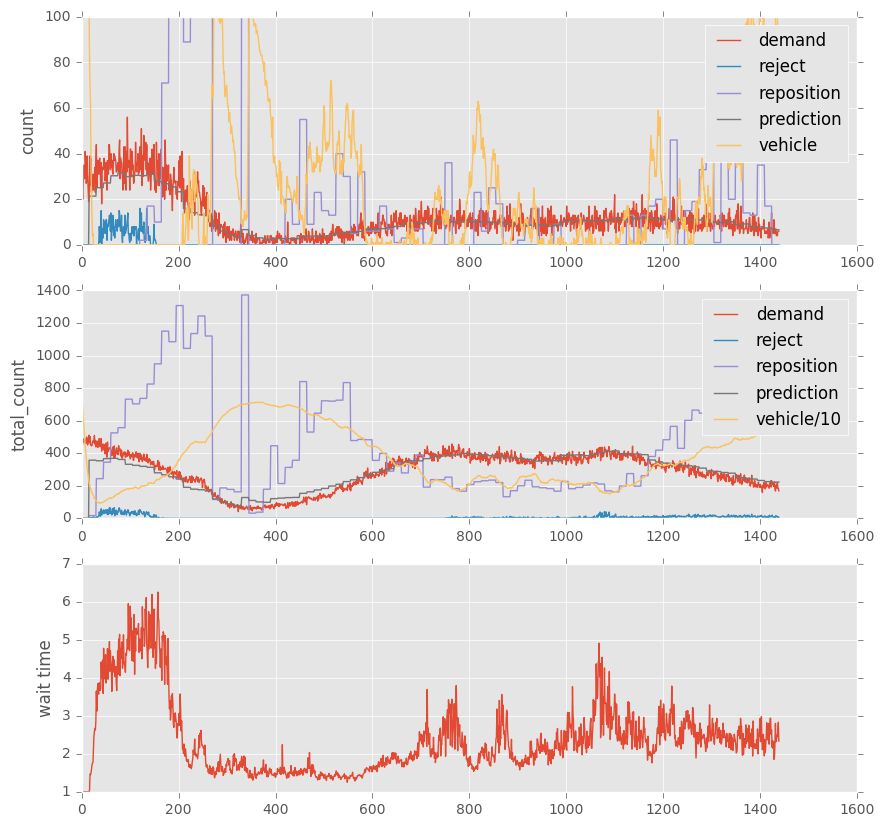

In [18]:
plot_result(result, reposition_cycle=rcycle);

In [19]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)

rcycle = 15
tmax = 25
rcost = 1.0
penalty = 30.0
svv_param = 0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_param=svv_param)

In [20]:
%%time
result = run(simulator, agent, T=60*24, reposition_cycle=rcycle)

hour 0: elapsed 0
t: 15	 total_flow: 16	 objective: 179553
t: 30	 total_flow: 237	 objective: 217942
t: 45	 total_flow: 333	 objective: 243825
hour 1: elapsed 119
t: 60	 total_flow: 501	 objective: 250146
t: 75	 total_flow: 549	 objective: 244646
t: 90	 total_flow: 683	 objective: 217028
t: 105	 total_flow: 655	 objective: 213883
hour 2: elapsed 232
t: 120	 total_flow: 684	 objective: 208858
t: 135	 total_flow: 756	 objective: 206560
t: 150	 total_flow: 921	 objective: 171690
t: 165	 total_flow: 1009	 objective: 155985
hour 3: elapsed 277
t: 180	 total_flow: 1044	 objective: 141523
t: 195	 total_flow: 1210	 objective: 123313
t: 210	 total_flow: 690	 objective: 68166
t: 225	 total_flow: 984	 objective: 64493
hour 4: elapsed 269
t: 240	 total_flow: 1042	 objective: 67284
t: 255	 total_flow: 952	 objective: 63932
t: 270	 total_flow: 77	 objective: 26588
t: 285	 total_flow: 249	 objective: 19457
hour 5: elapsed 206
t: 300	 total_flow: 192	 objective: 15990
t: 315	 total_flow: 200	 objectiv

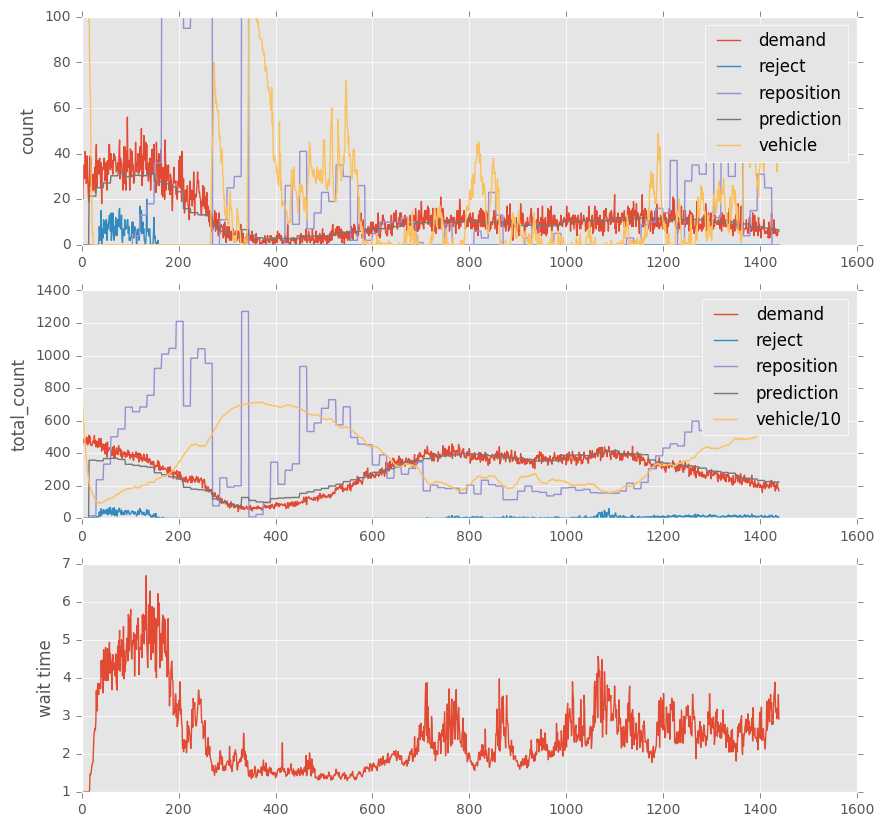

In [21]:
plot_result(result, reposition_cycle=rcycle);

In [23]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)

rcycle = 15
tmax = 25
rcost = 1
penalty = 25.0
svv_param = 0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_param=svv_param)

In [ ]:
%%time
result = run(simulator, agent, T=60*24, reposition_cycle=rcycle)

hour 0: elapsed 0
t: 15	 total_flow: 16	 objective: 150295
t: 30	 total_flow: 207	 objective: 183252
t: 45	 total_flow: 274	 objective: 205558
hour 1: elapsed 117
t: 60	 total_flow: 383	 objective: 212190
t: 75	 total_flow: 420	 objective: 210151
t: 90	 total_flow: 518	 objective: 189258
t: 105	 total_flow: 453	 objective: 188173
hour 2: elapsed 211
t: 120	 total_flow: 420	 objective: 185053
t: 135	 total_flow: 512	 objective: 184068
t: 150	 total_flow: 473	 objective: 156370
t: 165	 total_flow: 530	 objective: 147236
hour 3: elapsed 232
t: 180	 total_flow: 589	 objective: 140196
t: 195	 total_flow: 612	 objective: 131274
t: 210	 total_flow: 667	 objective: 89240
t: 225	 total_flow: 627	 objective: 79346
hour 4: elapsed 243
t: 240	 total_flow: 555	 objective: 79637
t: 255	 total_flow: 560	 objective: 77413
t: 270	 total_flow: 377	 objective: 36280
t: 285	 total_flow: 292	 objective: 22462
hour 5: elapsed 228
t: 300	 total_flow: 166	 objective: 13970
t: 315	 total_flow: 164	 objective: 

In [ ]:
plot_result(result, reposition_cycle=rcycle);

In [ ]:
summary(result)

In [24]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)

In [25]:
rcycle = 15
tmax = 25
rcost = 0
penalty = 30.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost, reject_penalty=penalty)

In [26]:
%%time
result = run(simulator, agent, T=60*24, reposition_cycle=rcycle)

hour 0
t: 15	 total_flow: 16	 objective: 179611	 elapsed: 30
t: 30	 total_flow: 235	 objective: 217898	 elapsed: 32
t: 45	 total_flow: 333	 objective: 244184	 elapsed: 36
hour 1
t: 60	 total_flow: 510	 objective: 249783	 elapsed: 45
t: 75	 total_flow: 551	 objective: 244093	 elapsed: 49
t: 90	 total_flow: 704	 objective: 216410	 elapsed: 55
t: 105	 total_flow: 698	 objective: 212257	 elapsed: 56
hour 2
t: 120	 total_flow: 778	 objective: 207133	 elapsed: 56
t: 135	 total_flow: 915	 objective: 203159	 elapsed: 64
t: 150	 total_flow: 879	 objective: 164749	 elapsed: 64
t: 165	 total_flow: 1053	 objective: 150706	 elapsed: 69
hour 3
t: 180	 total_flow: 1094	 objective: 134514	 elapsed: 68
0.0
t: 195	 total_flow: 1329	 objective: 114285	 elapsed: 73
0.0
Map Match Error (40.6860034802, -73.952447160299997)
t: 210	 total_flow: 611	 objective: 62720	 elapsed: 45
t: 225	 total_flow: 939	 objective: 61152	 elapsed: 48
hour 4
t: 240	 total_flow: 1049	 objective: 65499	 elapsed: 54
A* Path Error:

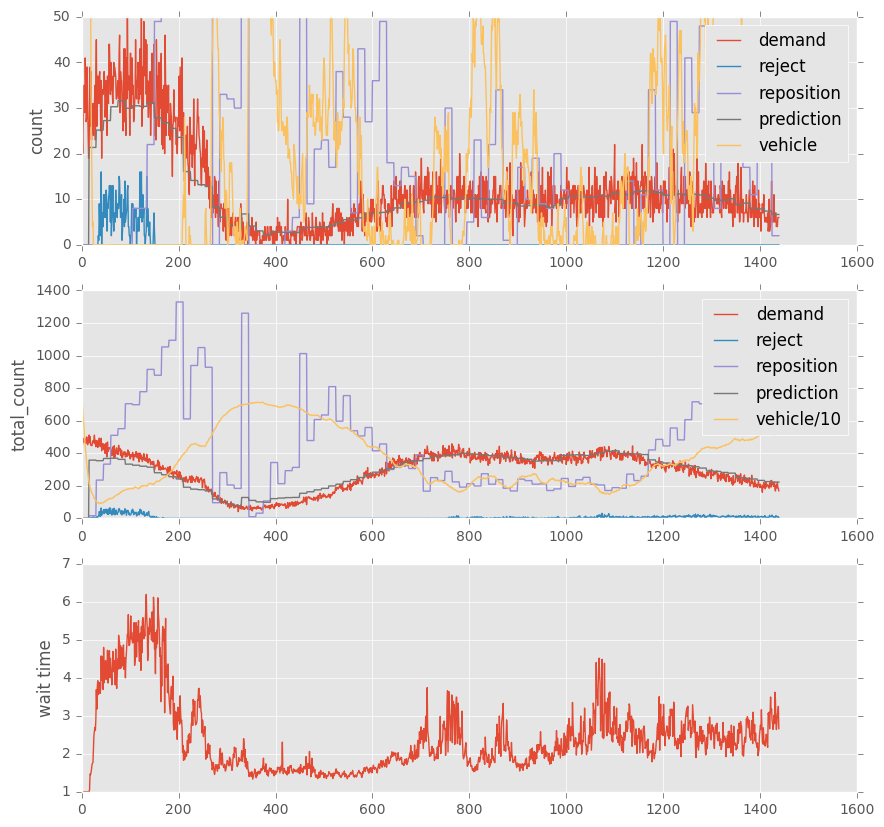

In [27]:
plot_result(result, reposition_cycle=rcycle);